In [ ]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))
import kaggle_support as kgs
import importlib
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
from dataclasses import dataclass, field, fields
import pack_cuda
import pack_vis
import pack_cost
import copy
import time
import pack_ga
from IPython.display import HTML, display, clear_output
pack_cuda.USE_FLOAT32 = True
pack_cuda._ensure_initialized()


local
stop final relax at some point
init CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -DENABLE_CRYSTAL_AXES -DENABLE_OVERLAP_AREA -DENABLE_SEPARATION -cubin /mnt/d//packing/temp/pack_cuda_saved.cu -o /mnt/d//packing/temp/pack_cuda_crystal.cubin
ptxas info    : 0 bytes gmem, 1172 bytes cmem[3]
ptxas info    : Compiling entry function 'multi_boundary_distance_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_distance_list_total
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 36 registers, 404 bytes cmem[0], 16 bytes cmem[2]
ptxas info    : Compiling entry function 'multi_boundary_list_total' for 'sm_89'
ptxas info    : Function properties fo

In [ ]:
%load_ext pyinstrument

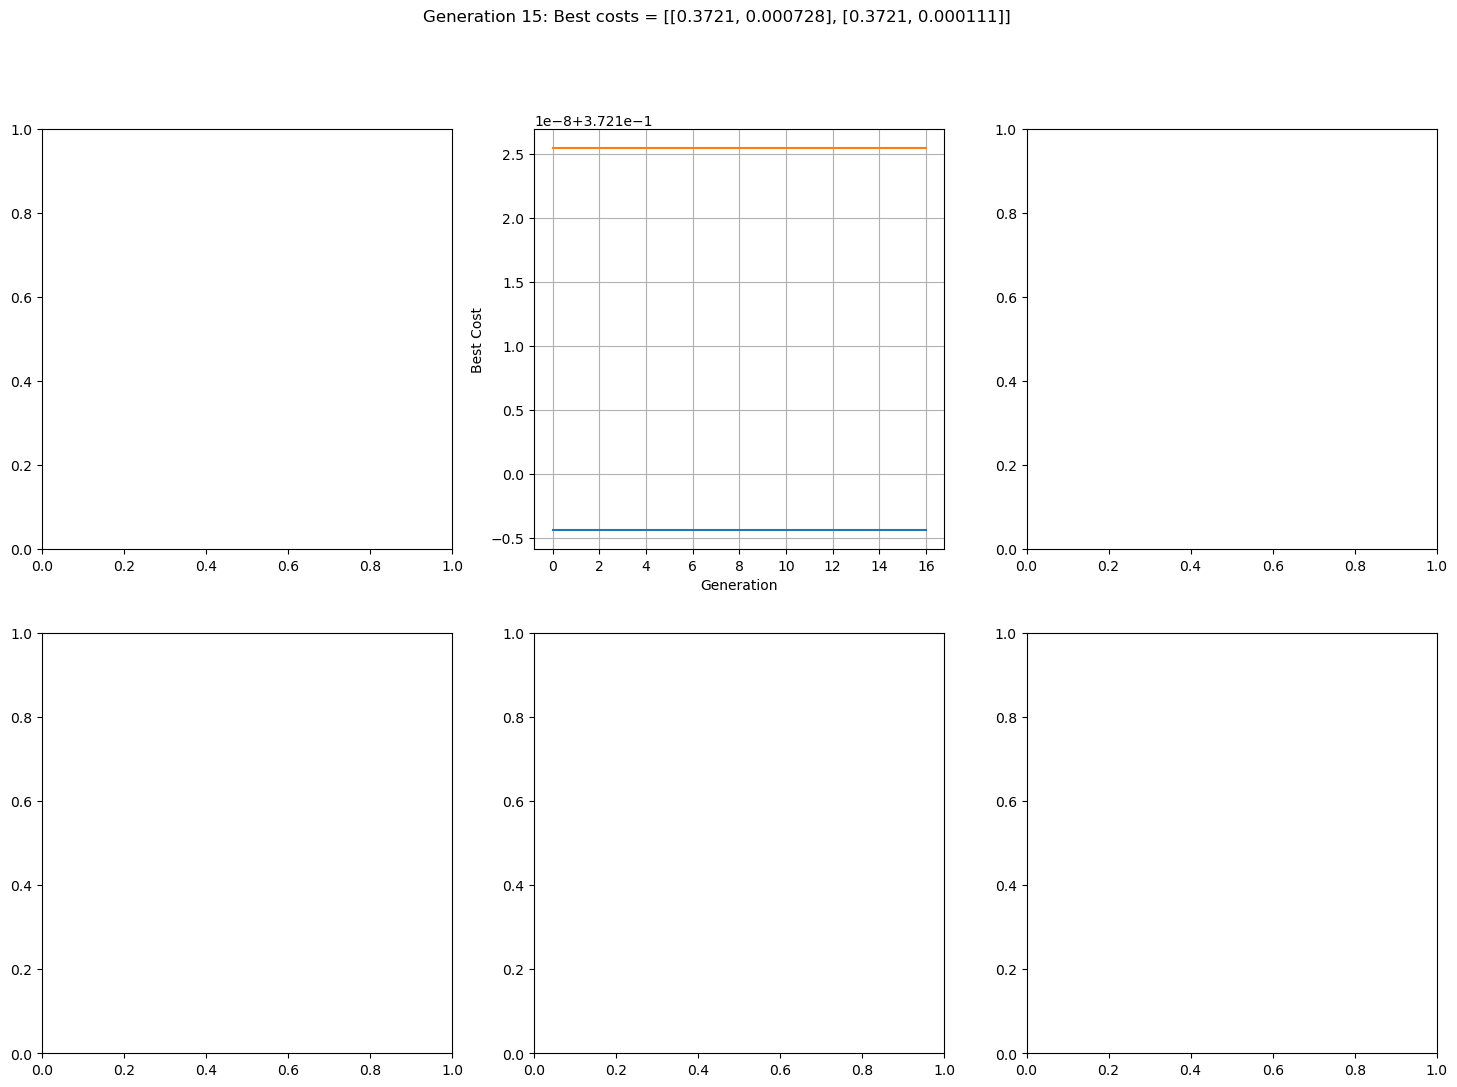

In [ ]:
#%%pyinstrument
#kgs.profiling=True
# %matplotlib widget
import pack_ga3 as pack_ga2
import pack_runner
importlib.reload(pack_ga2)
fastMode = True
kgs.debugging_mode = 2

tmp = pack_ga2.GA()

runner = pack_ga2.Orchestrator(n_generations=6000 if not fastMode else 50)
runner.ga = pack_ga2.GAMultiRing(N=16 if not fastMode else 4)
runner.ga.diversity_reset_threshold = 5./40
runner.ga.mate_distance=6

ga_base = pack_ga2.GASinglePopulationOld(N_trees_to_do=40)
#ga_base.population_size = 250
#ga_base.prob_mate_own = 0.25
value = 0.125
ga_base.population_size = int(ga_base.population_size * value)
ga_base.selection_size = [int( (s-1) * value)+1 for s in ga_base.selection_size]
ga_base.selection_size = ga_base.selection_size[:-6]
ga_base.do_legalize = False
ga_base.reset_check_generations = 50 if not fastMode else 3
ga_base.reset_check_threshold = 0.5 if not fastMode else 0.9
ga_base.freeze_duration = 100 if not fastMode else 3
#ga_base.move.moves[-1][2] *= 2
ga_base.prob_mate_own = 0.7
ga_base.reduce_h_threshold = 1e-5/40
ga_base.always_allow_mate_with_better = False
ga_base.fixed_h *= 1.01

runner.ga.ga_base = ga_base
runner.ga.do_legalize = not fastMode
runner.ga.allow_reset_ratio = 0.5 if not fastMode else 0.
#runner.ga.best_costs_per_generation_ax = ((0,False,(0,1)),)#( (0,False,(0,0)) ,(1,True,(0,1)))
#runner.ga.plot_subpopulation_costs_per_generation_ax = ( (0,False,(0,2)) ,(1,True,(1,2)))
#runner.ga.champion_genotype_ax = (1,0)
#runner.ga.champion_phenotype_ax = (0,0)
#runner.ga.plot_diversity_ax = (1,1)
runner.diagnostic_plot = True
runner.seed = 0

ga_list = []
for N_tree in [9,10]:
    ga_list.append( copy.deepcopy(runner.ga) )
    ga_list[-1].ga_base.N_trees_to_do = N_tree
runner.ga = pack_ga2.GAMulti(single_champion=False)
runner.ga.ga_list = ga_list
runner.ga.best_costs_per_generation_ax = ((0,False,(0,1)),)

runner.run()

In [ ]:
runner.ga.do_legalize = True
runner.ga.finalize()

Before optimization:  0.1395912915468216 1.6360565496142954e-05 3.7359731
After optimization:  0.13888557255268097 0.0003283306141383946 3.722328
After optimization:  0.13927295804023743 8.969534246716648e-05 3.7307274
After optimization:  0.1395418643951416 2.398004289716482e-05 3.7352095
After optimization:  0.13970336318016052 5.635450634144945e-06 3.7376158
After optimization:  0.13978341221809387 1.6035734233810217e-06 3.7387404
After optimization:  0.13983167707920074 3.4127418757634587e-07 3.7394028
After optimization:  0.13985204696655273 1.0035759601123573e-07 3.7396784
After optimization:  0.1398646980524063 2.593147918616978e-08 3.7398486
After optimization:  0.13987044990062714 9.285731294994548e-09 3.7399259
After optimization:  0.13987505435943604 2.3395458903507915e-09 3.7399874
After optimization:  0.1398763656616211 1.251752923536742e-09 3.740005
After optimization:  0.1398775428533554 6.128272334038343e-10 3.7400208
After optimization:  0.1398787945508957 1.4184557695

False